<a href="https://www.kaggle.com/code/bijaybeezoe/unsupervised-anomalydetection-using-isolationforet?scriptVersionId=281646883" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use("seaborn-v0_8")
sns.set()


# Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Basic Exploration

In [3]:
df.info()
df.describe()
df["Class"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    284315
1       492
Name: count, dtype: int64

# Preprocessing

## Keeping only numerical features

In [4]:
features = df.drop("Class", axis=1).values
labels = df["Class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Train Isolation Forest

In [5]:
fraud_ratio = df["Class"].mean()
fraud_ratio

0.001727485630620034

In [6]:
iso = IsolationForest(
    n_estimators=200,
    contamination=fraud_ratio,   
    max_samples="auto",
    random_state=42,
)

iso.fit(X_scaled)

IsolationForest(contamination=0.001727485630620034, n_estimators=200,
                random_state=42)

# Predict Anomalies

In [7]:
preds = iso.predict(X_scaled)
scores = iso.decision_function(X_scaled)

df["anomaly_score"] = scores
df["IF_prediction"] = preds
df["IF_label"] = df["IF_prediction"].map({1:0, -1:1})


# Evaluation

## Confusion Matrix

In [8]:
cm = confusion_matrix(labels, df["IF_label"])
cm

array([[283947,    368],
       [   368,    124]])

## Classification Report

In [9]:
print(classification_report(labels, df["IF_label"]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.25      0.25      0.25       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



# Visualization

## Score Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


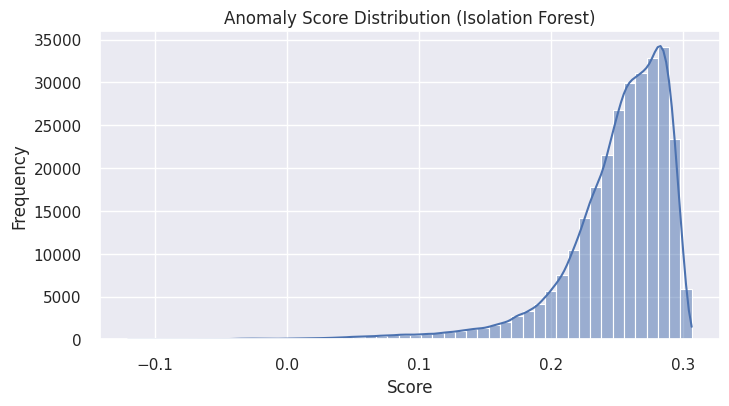

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(df["anomaly_score"], bins=50, kde=True)
plt.title("Anomaly Score Distribution (Isolation Forest)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

## Scatter Plot (Using PCA)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:,0]
df["PC2"] = X_pca[:,1]

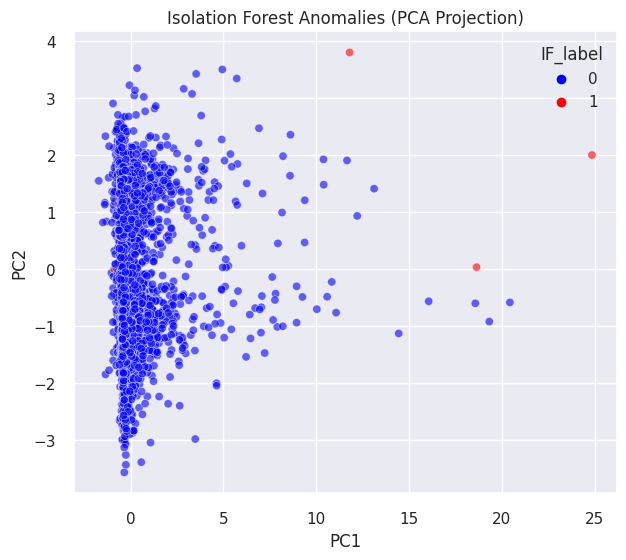

In [12]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=df.sample(5000, random_state=42),
    x="PC1",
    y="PC2",
    hue="IF_label",
    palette={0: "blue", 1: "red"},
    alpha=0.6
)
plt.title("Isolation Forest Anomalies (PCA Projection)")
plt.show()

## Compare Fraud vs Detected Anomalies

In [13]:
counts = pd.crosstab(df["Class"], df["IF_label"], rownames=["Actual"], colnames=["Predicted"])
counts

Predicted,0,1
Actual,,
0,283947,368
1,368,124


# Save Results

In [14]:
output_file = "isolation_forest_results.csv"
df.to_csv(output_file, index=False)

output_file

'isolation_forest_results.csv'

In [15]:
df.head

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V26       V27  \
0       0.462388  0.239599  0.